In [1]:
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import RFclass 

In [10]:
from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import ExtraTreesClassifier as RFC


from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
from scipy.interpolate import spline
from sklearn import metrics
from sklearn.metrics import accuracy_score

from sklearn.gaussian_process import GaussianProcess
import timeit

import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.interpolate import spline
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
import re
from astropy.io.fits.header import Header
from matplotlib.pyplot import xlim

%matplotlib inline

In [11]:

# Load data set and target values
start = timeit.default_timer()

####### Read the source data######################
df =pd.read_csv('Source_Data.csv', header=0)


p= Preprocessdata.standardprocess()

save_path = '/home/peng/git/Machine_learning_for_reliability_analysis/Ensemble/Results/'
result_name = 'ert_auc_10CV_.csv'

#train, trainlabel, test, testlabel = p.scaledivd(df, 0.8)
#print (np.shape(train))

*************************************change*


In [12]:
#### scale the training dataset first and then apply the rules to test set 
train, trainlabel, test, testlabel = p.noscale(df, 0.8)
#print (np.mean(testlabel))



In [13]:
print (np.mean(testlabel))

0.5


In [14]:
#define the BO function
seed = 'ert'
rad_stat = 2

def rfccv(n_estimators, max_features):
    return cross_val_score(RFC(n_estimators=int(n_estimators),                               
                               max_features=min(max_features, 0.999),
                               random_state=2),
                           train, trainlabel, 'roc_auc', cv=10, n_jobs = -1).mean()

In [15]:
rfcBO = BayesianOptimization(rfccv, {'n_estimators': (64, 128),                                         
                                         'max_features': (0.1, 0.999)})
rfcBO.maximize()

print('Final Results')
print('RF: %f' % rfcBO.res['max']['max_val'])

Initialization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    1 | 00m00s |    0.77480 |         0.8890 |        96.5260 | 
    2 | 00m00s |    0.80601 |         0.9818 |        90.9643 | 
    3 | 00m00s |    0.79396 |         0.3437 |        86.8492 | 
    4 | 00m00s |    0.77721 |         0.8830 |        77.2787 | 
    5 | 00m00s |    0.80890 |         0.1798 |        92.1946 | 
Bayesian Optimization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    6 | 00m03s |    0.79036 |         0.4422 |        91.7545 | 
    7 | 00m02s |    0.81066 |         0.1889 |        93.9311 | 
    8 | 00m02s |    0.81029 |         0.2062 |        91.8389 | 
    9 | 00m02s |    0.81066 |         0.2450 |        93.6348 | 
   10 | 00m02s |    0.80082 |         0.9990 |        87.6790 | 
   11 | 00m02s |    0.80686 |         0.2051 |        9

In [16]:
# use exploration to get better results
import random
from operator import add, sub

ops = (add, sub)
op = random.choice(ops)

tree_best = np.int(rfcBO.res['max']['max_params']['n_estimators'])
feature_best= np.float(rfcBO.res['max']['max_params']['max_features'])

new_tree_points, new_feature_points = [],[]

for i in xrange(0,5):
    new_tree_points.append(op(tree_best, tree_best*0.1*i) )
    new_feature_points.append(op(feature_best, feature_best*0.1*i) )



#new_feature_points = np.linspace(feature_best/2, feature_best*1.5, num = len(new_tree_points))
#new_feature_points.append(feature_best)

rfcBO_new = BayesianOptimization(rfccv, {'n_estimators': (64, 128),                                         
                                         'max_features': (0.1, 0.999)})
rfcBO_new.explore({'n_estimators': new_tree_points, 'max_features': new_feature_points})


rfcBO_new.maximize()

print('Final Results')
print('RF: %f' % rfcBO_new.res['max']['max_val'])


Initialization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
    1 | 00m00s |    0.81131 |         0.1841 |        89.0000 | 
    2 | 00m00s |    0.78926 |         0.1657 |        80.1000 | 
    3 | 00m00s |    0.78759 |         0.1473 |        71.2000 | 
    4 | 00m00s |    0.78620 |         0.1289 |        62.3000 | 
    5 | 00m00s |    0.78795 |         0.1105 |        53.4000 | 
    6 | 00m00s |    0.79249 |         0.6574 |        79.6980 | 
    7 | 00m00s |    0.79232 |         0.1084 |       116.5302 | 
    8 | 00m00s |    0.79768 |         0.7671 |        79.2411 | 
    9 | 00m00s |    0.77656 |         0.8664 |        65.1972 | 
   10 | 00m00s |    0.80473 |         0.2442 |        78.5796 | 
Bayesian Optimization
---------------------------------------------------------------
 Step |   Time |      Value |   max_features |   n_estimators | 
   11 | 00m03s |    0.79408 |         0.1100 |        8

In [17]:
# get the best parameters for plotting auc on training and test
if (1): ### True use the above best parameters, false use the recored best set
    tree_best = np.int(rfcBO_new.res['max']['max_params']['n_estimators'])
    feature_best= np.float(rfcBO_new.res['max']['max_params']['max_features'])
    print ('use the latest records')

else:
    tree_best = np.int(70.3800)
    feature_best=0.7260
    print ('use the historical records')


bestmodel= RFC(n_estimators = tree_best, max_features = feature_best).fit(train,trainlabel)

print (tree_best, feature_best)

use the latest records
89 0.184094346757


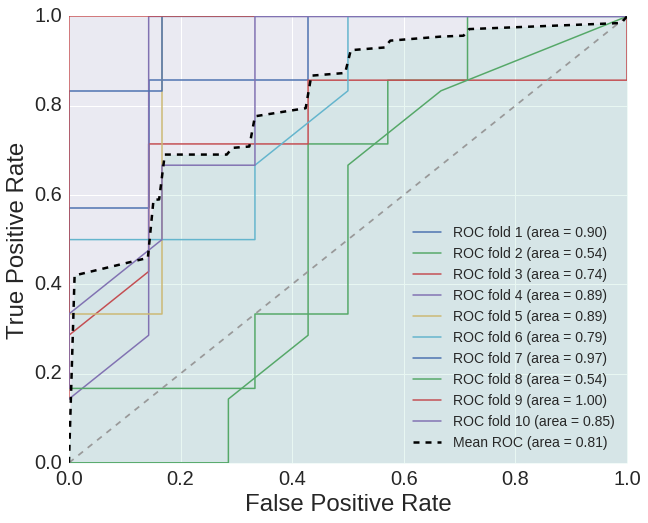

In [18]:
#use the best parameters to plot cv auc on the training set
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

figsize(10,8)
cv = StratifiedKFold(trainlabel, n_folds=10)

bestmodel_training= RFC(n_estimators = tree_best, max_features = feature_best, 
                            random_state = rad_stat)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (training, testing) in enumerate(cv):
    probas_ = bestmodel_training.fit(train[training], trainlabel[training]).predict_proba(train[testing])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(trainlabel[testing], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', 
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 14)

plt.fill_between(mean_fpr, 0, mean_tpr, #color="#348ABD", 
                 color="#66cdaa", alpha=0.15)
plt.show()

In [19]:
#predict the test set

tt=RFclass.test()

result = tt.testforest_score(test, testlabel,bestmodel)
print (result)

*******************************************
[[12  4]
 [ 4 12]]


*******************************************


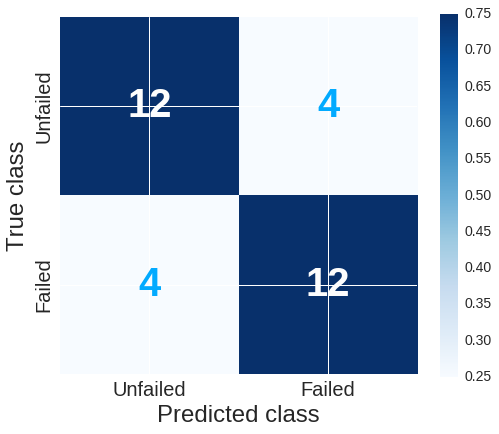

In [20]:
#plot the confusion matrix on test set
import Superplot
from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report

pp = Superplot.fancy()
pp.plot_confusion_matrix(result)

In [21]:
#plot the auc on test set
from sklearn.metrics import roc_curve, auc

y_score = bestmodel.predict_proba(test)
#print (y_score)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

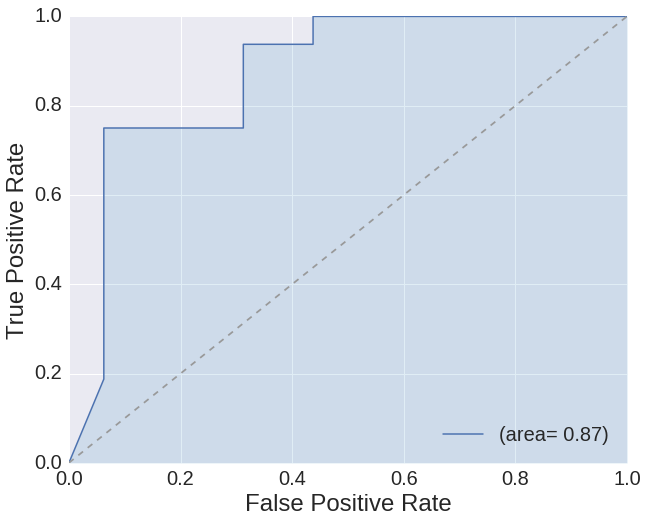

In [22]:
#plot the auc on test set
fpr, tpr, thresholds = roc_curve(testlabel, y_score[:, 1])
roc_auc = auc(fpr, tpr)

figsize(10,8)

plt.plot(fpr, tpr, lw=1.5, label='(area= %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 20)
sec = np.arange(0.0, 1.0, 0.05)
plt.fill_between(fpr, 0, tpr, color="#348ABD", alpha=0.15)
plt.show()

This is for training set**************************************
************************this is the output of relative importance**************
[ 0  3  2  7 10  1  8  9  6 11  5  4]
Feature ranking:
1. feature 0 (0.262603)
2. feature 3 (0.143318)
3. feature 2 (0.138149)
4. feature 7 (0.134443)
5. feature 10 (0.072599)
6. feature 1 (0.060208)
7. feature 8 (0.056091)
8. feature 9 (0.047332)
9. feature 6 (0.030820)
10. feature 11 (0.020448)
11. feature 5 (0.018446)
12. feature 4 (0.015544)


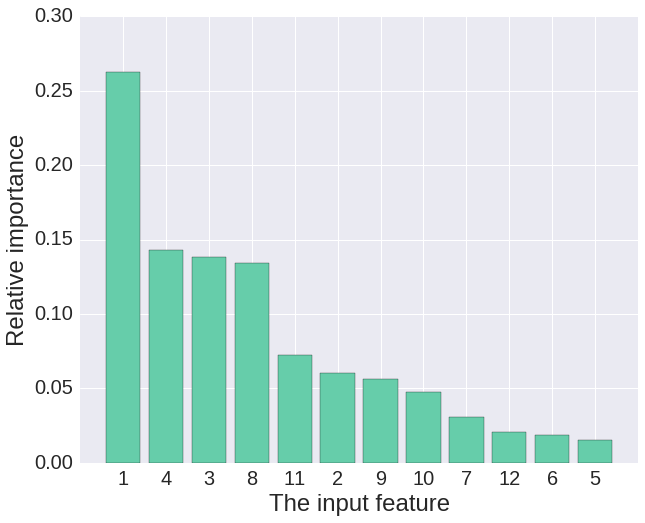

In [23]:
ff= RFclass.training()
ff.importance(bestmodel, 12, color = '#66cdaa', plot_std = False)


In [85]:
log_name = save_path + 'log_save/' + seed + '_OB.log'
logging.basicConfig(filename=log_name,level=logging.DEBUG)
logging.info("Seed : " + seed)
logging.info("Time start : " + str(start))
#logging.info("Time end :" + str(stop))
logging.info("Parameter setting :")
logging.info("range " + str(ex_range))
logging.info("C = " + str(svc_bayes.res['max']['max_params']['C']))
logging.info("gamma = " + str(svc_bayes.res['max']['max_params']['gamma']))

In [87]:
logging.shutdown()

In [19]:
for i in xrange(10):
    if i==5:
        break;
    print (i)

0
1
2
3
4
